
Congrats! You just graduated UVA's BSDS program and got a job working at a movie studio in Hollywood.

Your boss is the head of the studio and wants to know if they can gain a competitive advantage by predicting new movies that might get high imdb scores (movie rating).

You would like to be able to explain the model to mere mortals but need a fairly robust and flexible approach so you've chosen to use decision trees to get started.

In doing so, similar to great data scientists of the past you remembered the excellent education provided to you at UVA in a undergrad data science course and have outline 20ish steps that will need to be undertaken to complete this task. As always, you will need to make sure to #comment your work heavily.

Footnotes:

You can add or combine steps if needed
Also, remember to try several methods during evaluation and always be mindful of how the model will be used in practice.
Make sure all your variables are the correct type (factor, character,numeric, etc.)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [7]:
#1. Load the data
#Sometimes need to set the working directory back out of a folder that we create a file in

#import os
#os.listdir()
#print(os.getcwd())
#os.chdir('c:\\Users\\Brian Wright\\Documents\\3001Python\\DS-3001')

movie_metadata=pd.read_csv("/workspaces/DS-3021/data/movie_metadata.csv")
movie_metadata


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Color,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,...,6.0,English,Canada,NaN,NaN,2013.0,470.0,7.7,NaN,84
5039,Color,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,...,359.0,English,USA,TV-14,NaN,NaN,593.0,7.5,16.00,32000
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,...,3.0,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16
5041,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,...,9.0,English,USA,PG-13,NaN,2012.0,719.0,6.3,2.35,660


#2 Ensure all the variables are classified correctly including the target variable and collapse factor variables as needed.

#3 Check for missing variables and correct as needed. Once you've completed the cleaning again create a function that will do this for you in the future. In the submission, include only the function and the function call.

In [8]:
#the following preprocess function will preprocess our movie dataset
def preprocess_data(df):
    df = df.dropna(subset=["imdb_score"])
    df["rating_category"] = np.where(df["imdb_score"] > 7.2, "good", "bad") #create a new column where each movie is labeled as good if the IMDb score is greater than 7.2
    df["rating_category"] = df["imdb_score"].apply(lambda x: "good" if x > 7.2 else "bad")

    #drop these columns
    drop_columns = ["actor_1_name", "actor_3_name", "movie_title", "movie_imdb_link", "director_name", "director_facebook_likes", "actor_1_facebook_likes", "actor_2_facebook_likes", "actor_3_facebook_likes", "actor_2_name", "aspect_ratio", "facenumber_in_poster", "num_critic_for_reviews", "num_user_for_reviews", "movie_facebook_likes", "cast_total_facebook_likes",]
    df = df.drop(columns=drop_columns, errors="ignore")
    
    #now we process the content_rating column 
    df["content_rating"] = df["content_rating"].replace({"Unrated": "Not Rated","Not Rated": "Not Rated"}).apply(lambda x: x if x in ["R", "PG-13", "PG", "Not Rated"] else "Other") #replace unrated with not rated, and for columns that are notr, pg13, not rated, set those as other
    df["content_rating"] = df["content_rating"].astype('category')
    df['content_rating'] = LabelEncoder().fit_transform(df['content_rating']) #put the categorical values that we just converted to encode numerically 

    #now we do the same thing for other columns, this is kind of a tedious way but i think it makes it clea
    df["color"] = df["color"].apply(lambda x: 1 if x == "Color" else 0)
    df["color"] = df["color"].astype('category')
    df['color'] = LabelEncoder().fit_transform(df['color']) 


    df["plot_keywords"] = df["plot_keywords"].apply(
        lambda x: x.split("|")[0] if isinstance(x, str) and "|" in x else x
        )
    df["plot_keywords"] = df["plot_keywords"].astype('category')
    df['plot_keywords'] = LabelEncoder().fit_transform(df['plot_keywords']) 


    df["genres"] = df["genres"].apply(
          lambda x: x.split("|")[0] if isinstance(x, str) and "|" in x else x
        )
    df["genres"] = df["genres"].astype('category')
    df['genres'] = LabelEncoder().fit_transform(df['genres']) 

    
    df['country'] = df['country'].apply(lambda x: x if x in ["USA", "UK", "France", "Canada", "Germany"] else "Other")
    df["country"] = df["country"].astype('category')
    df['country'] = LabelEncoder().fit_transform(df['country']) 


    df['language'] = df['language'].apply(lambda x: x if x in ["English", "French", "Spanish"] else "Other")
    df["language"] = df["language"].astype('category')
    df['language'] = LabelEncoder().fit_transform(df['language']) 


    df.dropna(inplace=True) #remove any other rows with missing values
    
    #split it so X has all columns except for rating catgoery and imdb score becuase we ened those to make the rating category
    X = df.drop(columns=["rating_category", "imdb_score"])
    y = df["rating_category"] #y has the rating category 
    y = LabelEncoder().fit_transform(y)
    return X, y

#apply this function i jsut made to the movie dataset to get x and y for more anaylsis
X, y = preprocess_data(movie_metadata)


#4 Guess what, you don't need to scale the data, because DTs don't require this to be done, they make local greedy decisions...keeps getting easier, go to the next step.

#5 Determine the baserate or prevalence for the classifier, what does this number mean?

In [9]:
#we're finding the prevalence here and since we encoded good as 1 and bad as 0, ony the good is making an impact on the result even though we're comparing it to all the entries
baserate = np.mean(y)
print(baserate)

0.2300771208226221


The baserate tells us the overall proportion of movies in our dataset that have a high IMDb score (i.e., a score of 7.0 or higher). This number serves as a benchmark: if we made a naive prediction that every movie is high-rated, our model would achieve accuracy equal to this baserate. It also provides insight into class imbalance in the dataset, which is important for evaluating model performance.

#6 Split your data into test, tune, and train. (80/10/10)

In [10]:
#using temporary variable we can do all three in one line, did temp for 20% and split it in half to get the testing sets
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)
X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape[0]}")
print(f"Tune: {X_tune.shape[0]}")
print(f"Test: {X_test.shape[0]}")

Train: 3112
Tune: 389
Test: 389


#7 Create the kfold object for cross validation.

In [11]:
from sklearn.model_selection import KFold

#first split it in 5 folds, then shuffle the data before splitting so we're getting random distribution of the samples
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


#8 Create the scoring metric you will use to evaluate your model and the max depth hyperparameter (grid search)

In [12]:
#accuracy measures the proportion of correct predictions out of all predictions
scoring_metric = 'accuracy'
#because max depth controls the depth of the tree; none means that the nodes will continue to expand until it's pure
param_grid = {'max_depth': [None, 5, 10, 15, 20]}

#9 Build the classifier object 

In [13]:
from sklearn.tree import DecisionTreeClassifier
#set up the descision tree classifier
classifier = DecisionTreeClassifier(random_state=42)

#10 Use the kfold object and the scoring metric to find the best hyperparameter value for max depth via the grid search method.

In [14]:
#set up the grid search with decision tree classifier, param grid, and kfold
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=kfold, scoring=scoring_metric)

#11 Fit the model to the training data.

In [15]:
#did grid search on traiing data to find the best max depth then train the tree to find the depth
grid_search.fit(X_train, y_train)
best_depth = grid_search.best_params_["max_depth"]
decisiontree_model = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
decisiontree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

#12 What is the best depth value?

In [16]:
#print the best depth value found in the last step in the grid search
print("The best max_depth:", best_depth)

The best max_depth: 10


#13 Print out the model

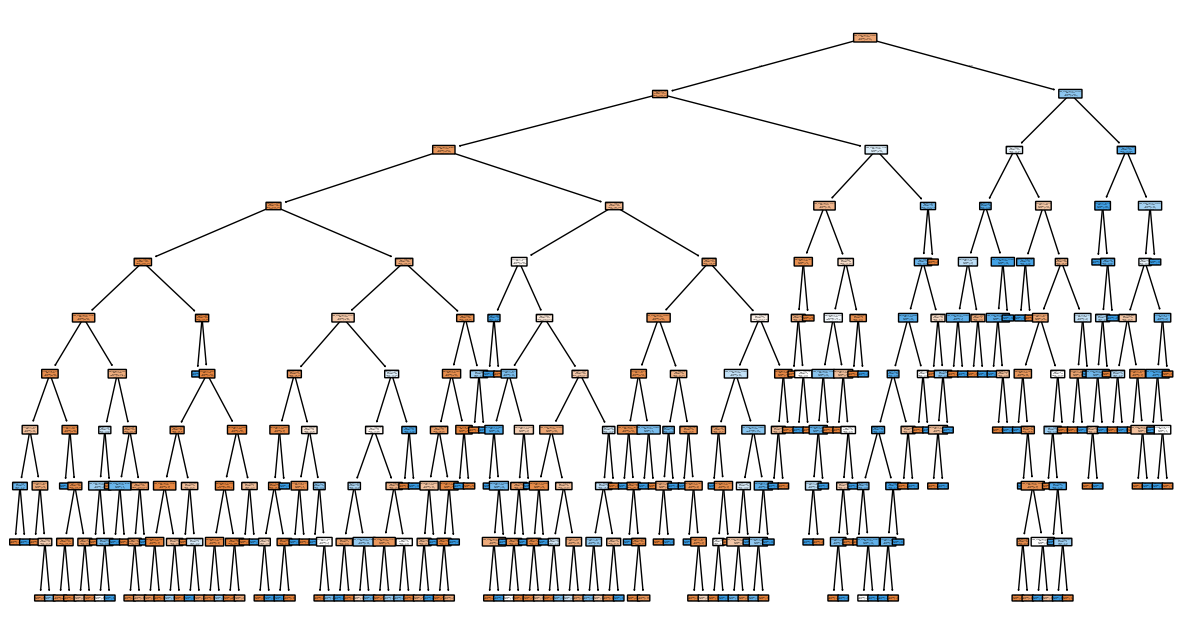

In [17]:
#print the decision tree model
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 8))
plot_tree(decisiontree_model, feature_names=X.columns, class_names=["bad", "good"], filled=True, rounded=True)
plt.show()

#14 View the results, comment on how the model performed using several evaluation metrics.

In [21]:
#generate predictions on the tuning dataset
from sklearn.metrics import accuracy_score, classification_report
y_predictive_tune = decisiontree_model.predict(X_tune)
print("Tuning grid search:", accuracy_score(y_tune, y_predictive_tune))
print("Classification report:\n", classification_report(y_tune, y_predictive_tune)) #using \n so it looks better

Tuning grid search: 0.8226221079691517
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89       295
           1       0.68      0.51      0.58        94

    accuracy                           0.82       389
   macro avg       0.77      0.72      0.73       389
weighted avg       0.81      0.82      0.81       389



The model has a decent overall accuracy at 82%. it's doing better based on the classification report, especally bette ron class 0 when compared to class 1.the model has a hard time to identify class 1 objects which can be seen from the lower f1 score for that particular class.

#15 Which variables appear to be contributing the most (variable importance) 

In [22]:
#took feature importances from the trained decision tree model and made a series mapping each feature to its importance
importances = decisiontree_model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feature_importance)

num_voted_users    0.399912
duration           0.122257
budget             0.115271
gross              0.106136
title_year         0.068463
language           0.056624
plot_keywords      0.054359
genres             0.043798
content_rating     0.020329
country            0.008504
color              0.004348
dtype: float64


#16 Use the predict method on the test data and print out the results.

In [24]:
print("Tune Set Predictions:", y_predictive_tune[:10])

Tune Set Predictions: [0 0 1 0 0 0 1 0 0 1]


#17 How does the model perform on the tune data?

Based on the tuning data, the model does a pretty good job overall by getting high accuracy. However, the classification report shows that while some classes are predicted really well, others might be a bit off. This means the model could benefit from some more tuning in ths future, especially for the classes that aren’t performing as strong.

#18 Print out the confusion matrix for the test data, what does it tell you about the model?

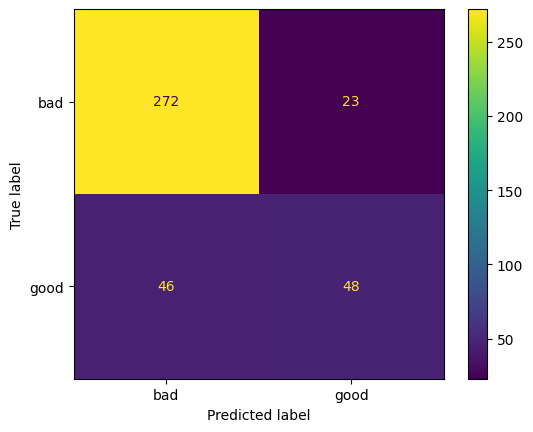

In [25]:
print(ConfusionMatrixDisplay(confusion_matrix(y_tune, y_predictive_tune), display_labels=["bad", "good"]).plot())

#this is printing the confusion matrix for the tuning data

#19 What are the top 3 movies based on the test set? Which variables are most important in predicting the top 3 movies?

In [29]:
#append the predicted ratings to the tuning set, then choose the top 3 movies based on ratings 
X_tune["predicted_rating"] = y_predictive_tune
top_movies = X_tune.sort_values("predicted_rating", ascending=False).head(3)
print("top 3 movies:\n", top_movies)

top_movie_indices = top_movies.index  #have to make it a variable so we can use it in the next line
top_movie_titles = movie_metadata.loc[top_movie_indices, "movie_title"]
top_movie_titles = top_movie_titles.str.strip()

print("top 3 movies:", top_movie_titles.tolist())

top 3 movies:
       color  duration       gross  genres  num_voted_users  plot_keywords  \
3079      1     161.0  56715371.0       1           427357            267   
2906      1      94.0   9030581.0       7           132386            767   
4328      0      92.0      7927.0       5            19236           1897   

      language  country  content_rating      budget  title_year  \
3079         0        4               1  12000000.0      1968.0   
2906         0        4               3  12500000.0      2008.0   
4328         0        5               0   2300000.0      1947.0   

      predicted_rating  
3079                 1  
2906                 1  
4328                 1  
top 3 movies: ['2001: A Space Odyssey', 'The Boy in the Striped Pajamas', 'The Lady from Shanghai']


#20 Use a different hyperparameter for the grid search function and go through the process above again using the tune set.

In [ ]:
#similar to 10
param_grid_new = {"max_depth": range(1, 4)}
grid_search_new = GridSearchCV(classifier, param_grid_new, cv=kfold, scoring=scoring_metric)
grid_search_new.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': range(1, 4)}, scoring='accuracy')

#21 Did the model improve with the new hyperparameter search?

In [36]:
new_best = grid_search_new.best_params_["max_depth"]
print(f"new best max_depth: {new_best}")

#3 is a better max depth because we had 10 as the max depth earlier and that would cause the issue of overfitting

new best max_depth: 3


#22 Using the better model, predict the test data and print out the results.

In [39]:
#make a new decision tree and train that on the training data and predict the test labels
new_model = DecisionTreeClassifier(max_depth=new_best, random_state=42)
new_model.fit(X_train, y_train)

y_test_pred = new_model.predict(X_test)
print("accuracy:", accuracy_score(y_test, y_test_pred))
print("classification report:\n", classification_report(y_test, y_test_pred))

accuracy: 0.8226221079691517
classification report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89       299
           1       0.74      0.36      0.48        90

    accuracy                           0.82       389
   macro avg       0.79      0.66      0.69       389
weighted avg       0.81      0.82      0.80       389



#23 Summarize what you learned along the way and make recommendations to your boss on how this could be used moving forward, being careful not to over promise.

During this project, I did a more advanced cleaning in otder to prepare our movie dataset so that it's ready for modeling. I developed a decision tree classifier and examined with tuning using parameters like max depth to split nodes. We now have a better picture of wher the model performs well and where it could improve by using accuracy scores, confusion matrixes, and other reports. We also looked at which features would most influence the prredictions to get a better understanding of what affects imdb ratings. 

In the future, we could try using more advanced techniques like random foresets to cpature more nuances in the data. i would also suggest not to solely rely on this report even though it shows promising results. We should instead use multple tools to make decisions. 